In [459]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

In [460]:
# Carrega o dataset de treino
data_train = pd.read_csv('treino.csv')
data_train.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,50,female,38091,bachelor,3,hiking,1308,rural,41,85,spring,0,0,1
1,47,non-binary,50274,high school,6,hiking,2306,urban,239,218,summer,0,1,0
2,41,female,43443,doctorate,8,sunbathing,2351,rural,222,173,winter,1,0,0
3,69,non-binary,62584,doctorate,9,sunbathing,1068,urban,140,76,summer,0,1,0
4,68,male,55805,bachelor,1,sunbathing,4704,suburban,296,201,winter,1,1,0


In [461]:
# Carrega o dataset de teste
data_test = pd.read_csv('teste.csv')
data_test.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,31,non-binary,45179,high school,3,sunbathing,959,suburban,173,154,summer,1,0,0
1,51,male,47442,bachelor,5,hiking,756,suburban,8,289,summer,0,1,1
2,26,male,92894,high school,0,sunbathing,804,rural,287,203,winter,1,0,0
3,58,male,104297,doctorate,5,skiing,2143,urban,286,84,summer,1,0,0
4,56,male,95662,high school,2,swimming,4627,suburban,299,121,spring,0,0,0


In [462]:
# Verifica a dimensão dos dados de treino e teste
print(f'Dimensão dos dados de treino: {data_train.shape}\n')
print(f'Dimensão dos dados de teste: {data_test.shape}\n')

Dimensão dos dados de treino: (41955, 14)

Dimensão dos dados de teste: (10489, 14)



In [463]:
# Criação de Features de treino
data_train['Average_Proximity'] = (data_train['Proximity_to_Mountains'] + data_train['Proximity_to_Beaches']) / 2
data_train['Total_Travel_Expenditure'] = data_train['Travel_Frequency'] * data_train['Vacation_Budget']
data_train['Income_Per_Age'] = data_train['Income'] / data_train['Age']
data_train['Is_Graduate'] = data_train['Education_Level'].apply(lambda x: 1 if x in ['bachelor', 'master', 'doctorate'] else 0)

# Criação de Features de teste
data_test['Average_Proximity'] = (data_test['Proximity_to_Mountains'] + data_test['Proximity_to_Beaches']) / 2
data_test['Total_Travel_Expenditure'] = data_test['Travel_Frequency'] * data_test['Vacation_Budget']
data_test['Income_Per_Age'] = data_test['Income'] / data_test['Age']
data_test['Is_Graduate'] = data_test['Education_Level'].apply(lambda x: 1 if x in ['bachelor', 'master', 'doctorate'] else 0)

In [464]:
# Função para visualizar dados numéricos e categóricos do conjunto de dados
def analise_grafica(dataframe, dataset_name="Dataset"):
    # Separar colunas numéricas e categóricas
    numeric_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    
    print(f"Análise Gráfica para {dataset_name}")
    
    # Histograma para variáveis numéricas
    dataframe[numeric_columns].hist(bins=20, figsize=(15, 10))
    plt.suptitle(f'Distribuição das Variáveis Numéricas - {dataset_name}', fontsize=16)
    plt.show()

    # Gráficos de barras para variáveis categóricas
    num_cols = 3  # Número de colunas na plotagem
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Número de linhas necessárias
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_columns):
        sns.countplot(data=dataframe, x=col, ax=axes[i], palette="muted", hue=col, dodge=False, legend=False)
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].tick_params(axis='x', rotation=45)

    # Remover subplots não utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Heatmap de correlação para variáveis numéricas
    plt.figure(figsize=(12, 10))
    sns.heatmap(dataframe[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Mapa de Correlação das Variáveis Numéricas - {dataset_name}')
    plt.show()

### Explicação dos Termos Estatísticos

- **count**: Número total de observações não nulas para a coluna.
- **unique**: Número de valores únicos na coluna (somente para dados categóricos).
- **top**: O valor mais frequente (somente para dados categóricos).
- **freq**: Frequência do valor mais frequente (somente para dados categóricos).
- **mean**: Média aritmética dos valores (somente para dados numéricos).
- **std**: Desvio padrão dos valores, indicando a dispersão em torno da média (somente para dados numéricos).
- **min**: Valor mínimo encontrado na coluna (somente para dados numéricos).
- **25% (1º quartil)**: O valor abaixo do qual 25% dos dados estão (somente para dados numéricos).
- **50% (mediana)**: O valor central que divide os dados em duas partes iguais (somente para dados numéricos).
- **75% (3º quartil)**: O valor abaixo do qual 75% dos dados estão (somente para dados numéricos).
- **max**: Valor máximo encontrado na coluna (somente para dados numéricos).

In [465]:
# Estatísticas sobre as variáveis numéricas de treino
data_train.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate
count,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000
mean,43.485377,69962.115266,4.486045,2738.369563,150.243857,149.814802,0.500417,0.499249,0.250459,150.029329,12304.495412,1853.699774,0.751067
std,14.983641,28807.077116,2.878217,1296.702674,86.530175,86.485913,0.500006,0.500005,0.433282,61.058551,10533.903627,1119.819891,0.432400
min,18.000000,20003.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290.695652,0.000000
25%,31.000000,45005.500000,2.000000,1619.000000,75.000000,75.000000,0.000000,0.000000,0.000000,106.500000,3910.000000,1031.555603,1.000000
50%,43.000000,70012.000000,4.000000,2725.000000,151.000000,150.000000,1.000000,0.000000,0.000000,149.500000,9420.000000,1609.645833,1.000000
75%,56.000000,95008.000000,7.000000,3865.500000,225.000000,224.000000,1.000000,1.000000,1.000000,194.000000,18745.500000,2367.125000,1.000000
max,69.000000,119999.000000,9.000000,4999.000000,299.000000,299.000000,1.000000,1.000000,1.000000,298.000000,44982.000000,6654.111111,1.000000


Análise Gráfica para treino.csv


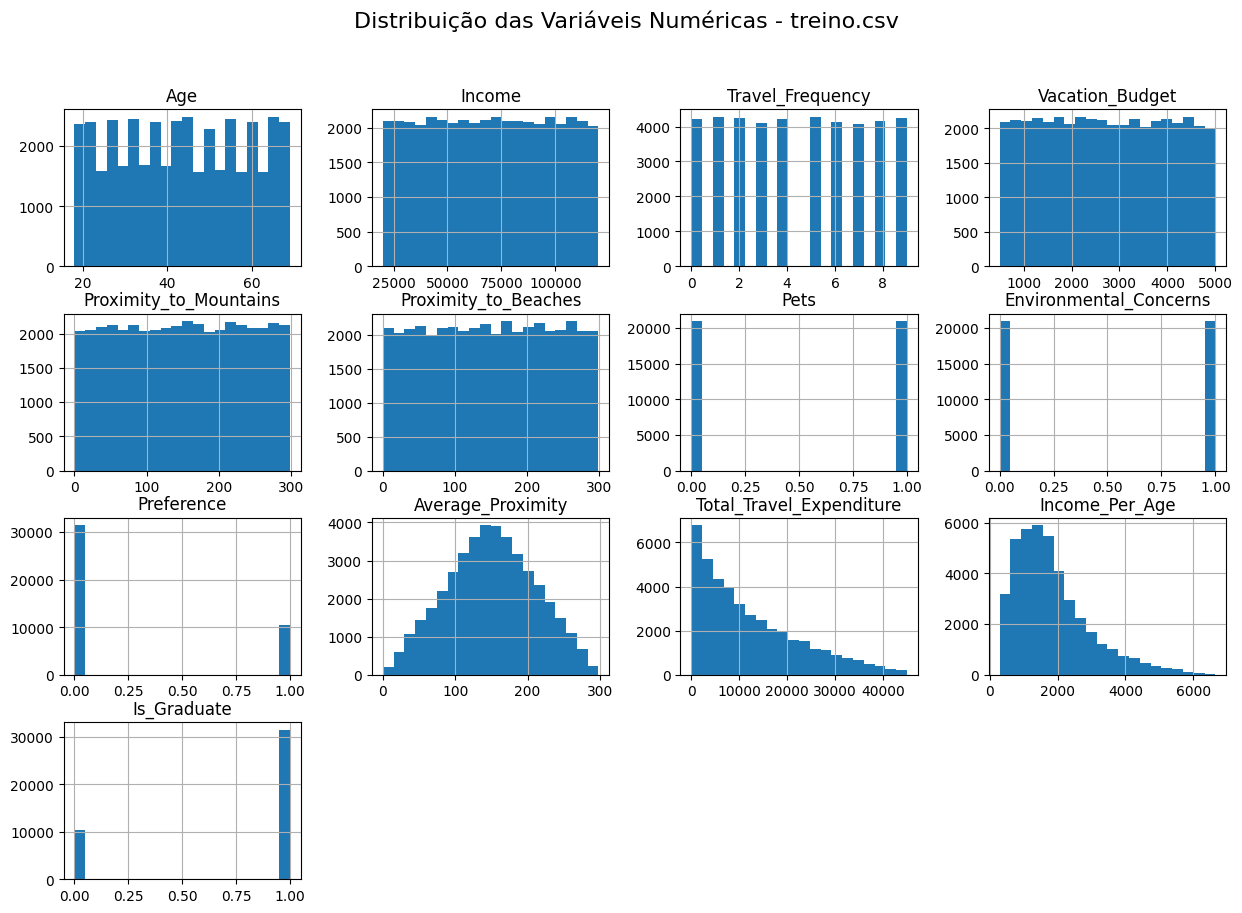

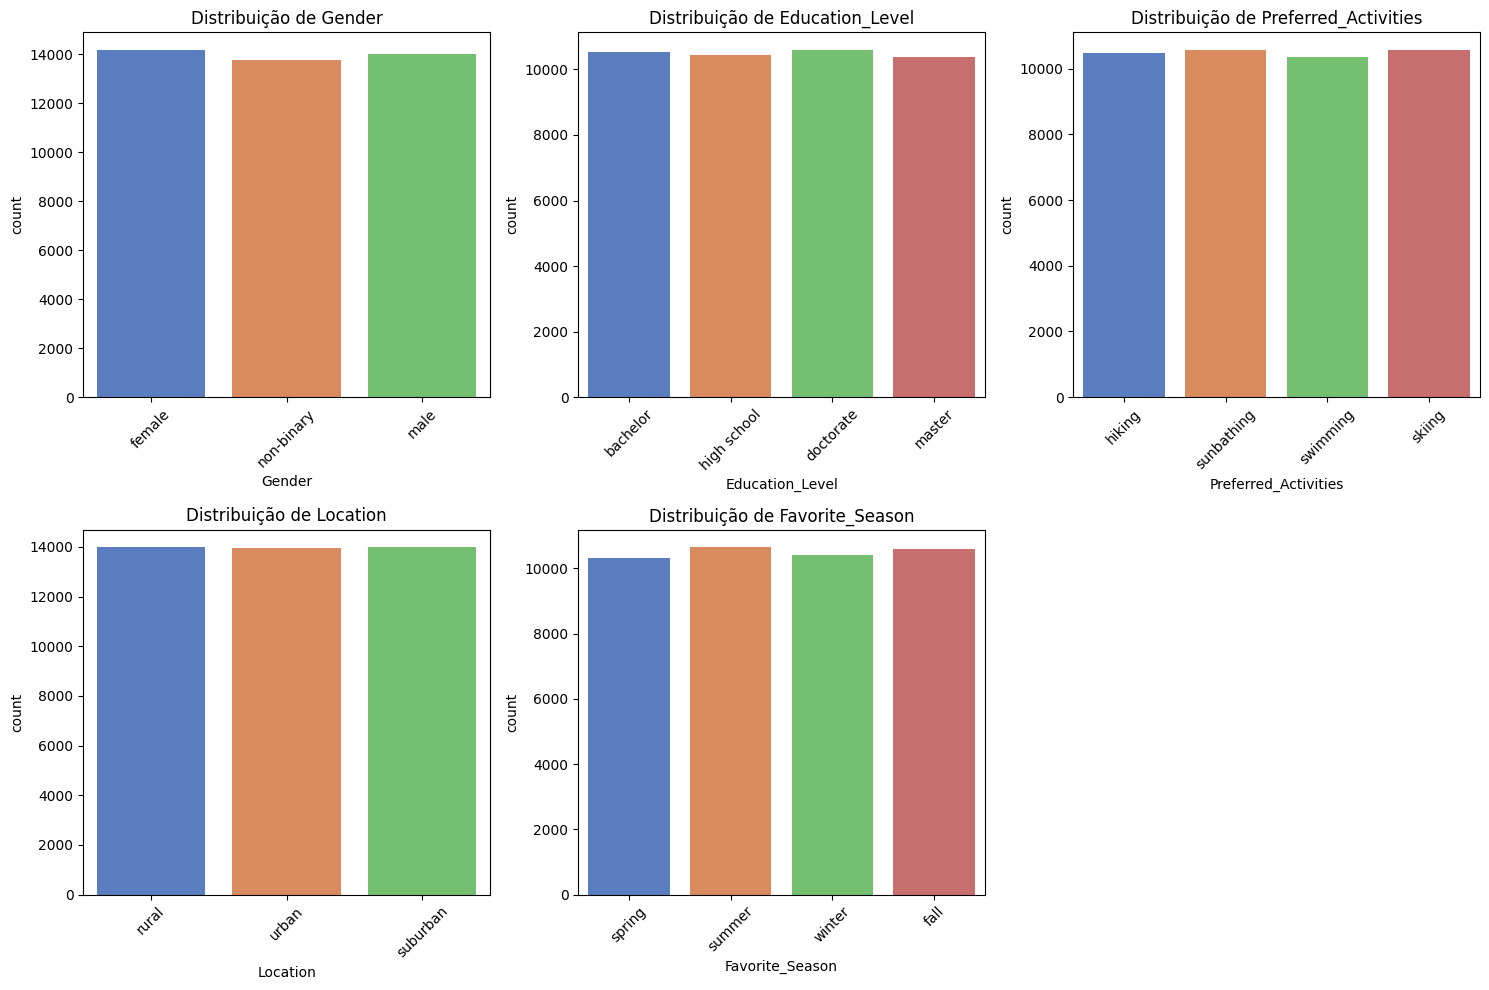

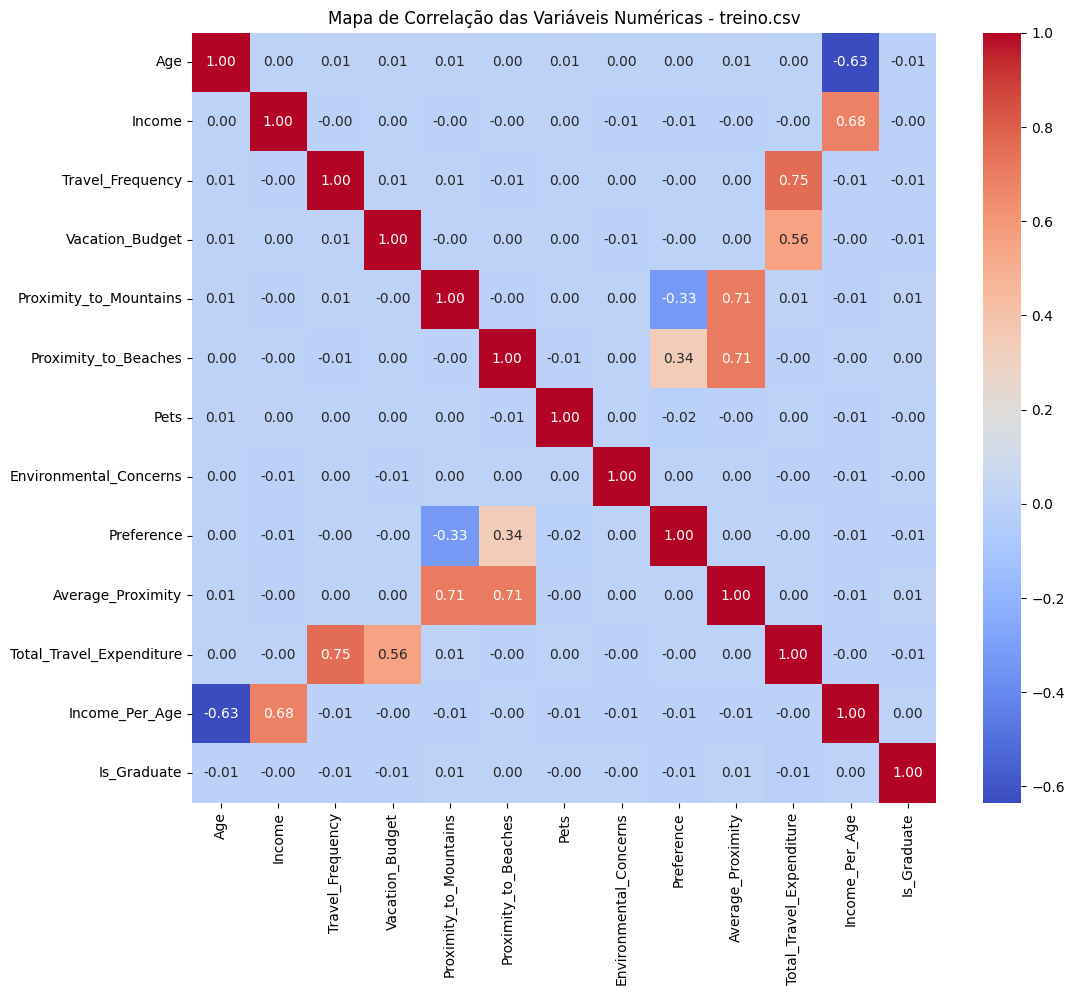

In [466]:
# Análise gráfca do treino
analise_grafica(data_train, "treino.csv")

In [467]:
# Estatísticas sobre as variáveis numéricas de teste
data_test.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate
count,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000
mean,43.595290,70237.890075,4.502145,2755.516732,148.742111,150.183049,0.502622,0.495185,0.251692,149.462580,12392.341501,1859.568206,0.749452
std,14.993811,29009.255241,2.867866,1297.772245,86.616191,86.406047,0.500017,0.500001,0.434006,61.507999,10487.258811,1129.338139,0.433349
min,18.000000,20001.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,301.352941,0.000000
25%,31.000000,45152.000000,2.000000,1639.000000,73.000000,77.000000,0.000000,0.000000,0.000000,105.500000,3916.000000,1033.088889,0.000000
50%,43.000000,70789.000000,5.000000,2757.000000,149.000000,150.000000,1.000000,0.000000,0.000000,149.500000,9656.000000,1620.200000,1.000000
75%,57.000000,95434.000000,7.000000,3881.000000,224.000000,226.000000,1.000000,1.000000,1.000000,193.500000,18780.000000,2379.441860,1.000000
max,69.000000,119995.000000,9.000000,4998.000000,299.000000,299.000000,1.000000,1.000000,1.000000,297.000000,44919.000000,6641.722222,1.000000


Análise Gráfica para teste.csv


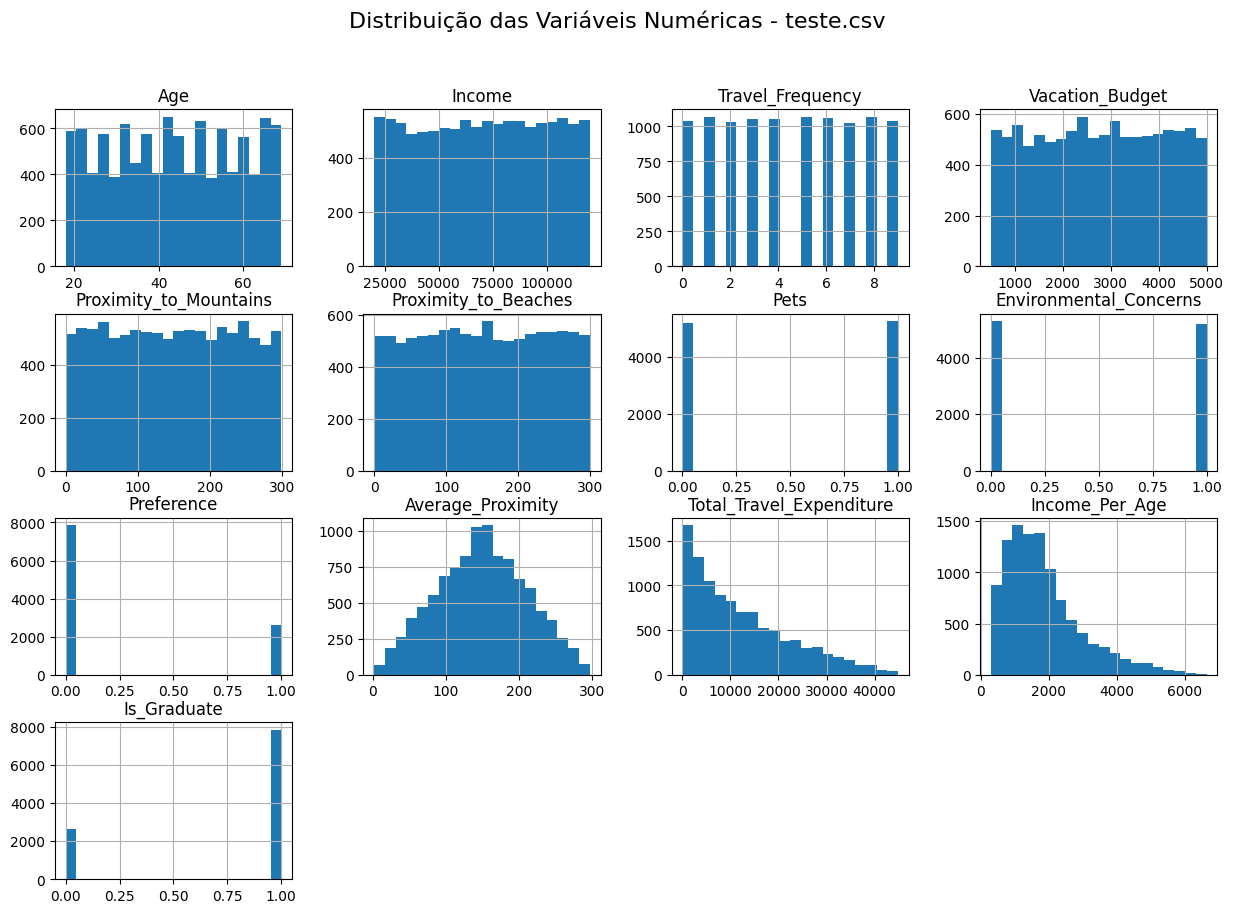

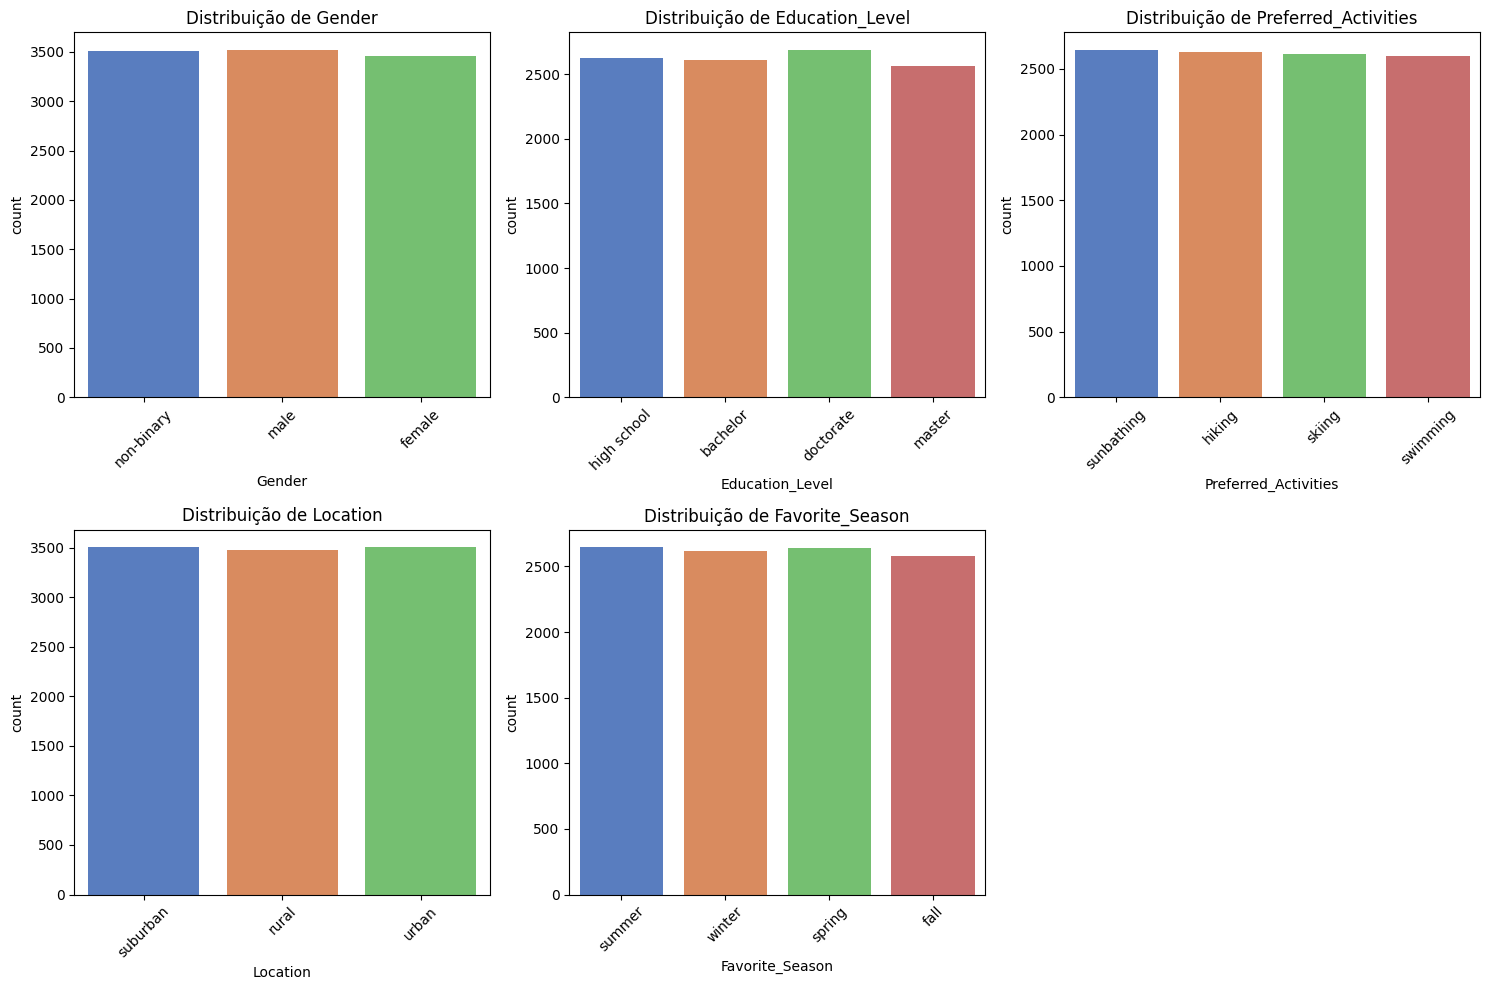

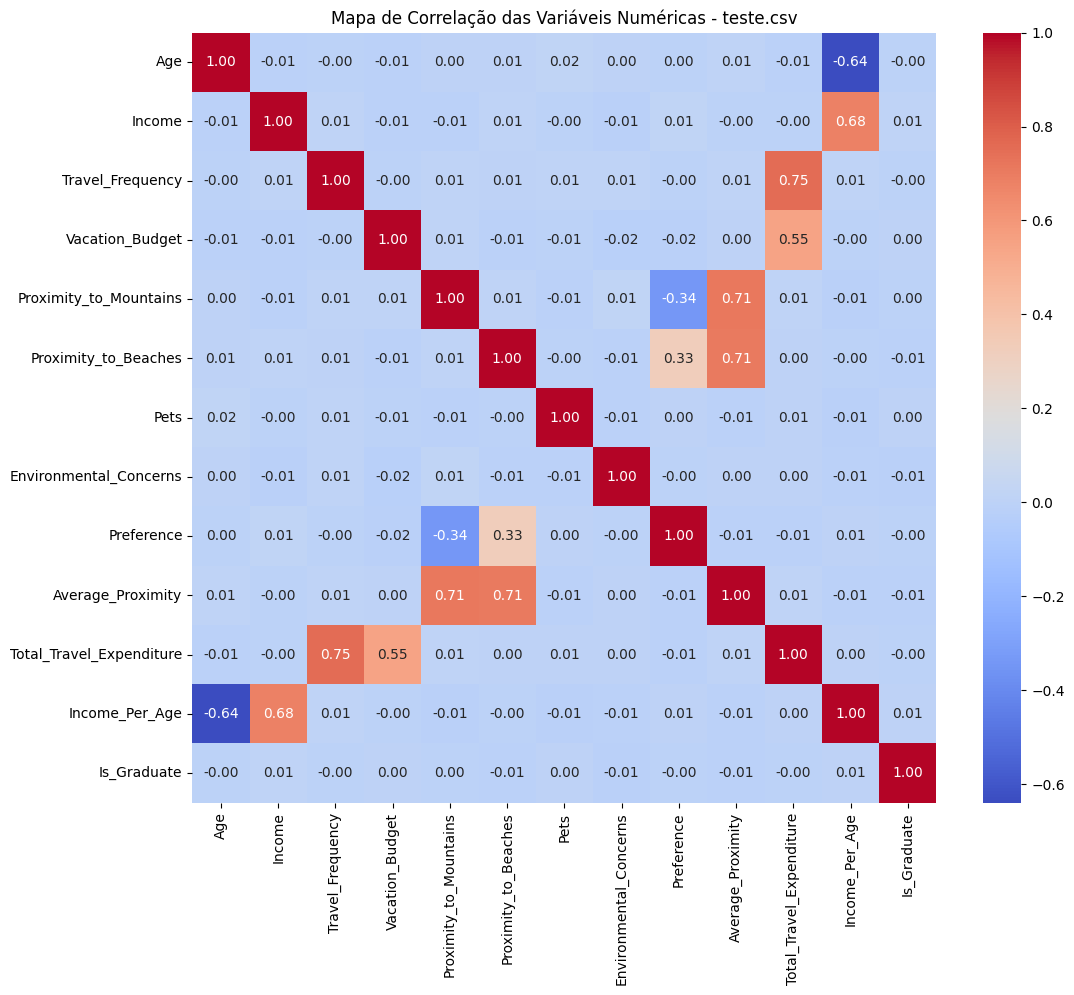

In [468]:
# Análise gráfca do teste
analise_grafica(data_test, "teste.csv")

In [469]:
# Lista de variáveis categóricas
colunas_cat = data_train.select_dtypes(include=['object']).columns.tolist()

# Estatísticas sobre as variáveis categóricas
for coluna in colunas_cat:
    print(f'### Coluna <{coluna}> ###')
    print(data_train[coluna].value_counts())
    print('-' * 40)

### Coluna <Gender> ###
Gender
female        14179
male          13999
non-binary    13777
Name: count, dtype: int64
----------------------------------------
### Coluna <Education_Level> ###
Education_Level
doctorate      10602
bachelor       10518
high school    10444
master         10391
Name: count, dtype: int64
----------------------------------------
### Coluna <Preferred_Activities> ###
Preferred_Activities
sunbathing    10575
skiing        10551
hiking        10470
swimming      10359
Name: count, dtype: int64
----------------------------------------
### Coluna <Location> ###
Location
suburban    13997
rural       13990
urban       13968
Name: count, dtype: int64
----------------------------------------
### Coluna <Favorite_Season> ###
Favorite_Season
summer    10655
fall      10593
winter    10399
spring    10308
Name: count, dtype: int64
----------------------------------------


In [470]:
# Lista de variáveis categóricas
colunas_cat = data_test.select_dtypes(include=['object']).columns.tolist()

# Estatísticas sobre as variáveis categóricas
for coluna in colunas_cat:
    print(f'### Coluna <{coluna}> ###')
    print(data_test[coluna].value_counts())
    print('-' * 40)

### Coluna <Gender> ###
Gender
male          3523
non-binary    3507
female        3459
Name: count, dtype: int64
----------------------------------------
### Coluna <Education_Level> ###
Education_Level
doctorate      2691
high school    2628
bachelor       2609
master         2561
Name: count, dtype: int64
----------------------------------------
### Coluna <Preferred_Activities> ###
Preferred_Activities
sunbathing    2646
hiking        2632
skiing        2616
swimming      2595
Name: count, dtype: int64
----------------------------------------
### Coluna <Location> ###
Location
urban       3508
suburban    3506
rural       3475
Name: count, dtype: int64
----------------------------------------
### Coluna <Favorite_Season> ###
Favorite_Season
summer    2648
spring    2644
winter    2620
fall      2577
Name: count, dtype: int64
----------------------------------------


In [471]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41955 entries, 0 to 41954
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       41955 non-null  int64  
 1   Gender                    41955 non-null  object 
 2   Income                    41955 non-null  int64  
 3   Education_Level           41955 non-null  object 
 4   Travel_Frequency          41955 non-null  int64  
 5   Preferred_Activities      41955 non-null  object 
 6   Vacation_Budget           41955 non-null  int64  
 7   Location                  41955 non-null  object 
 8   Proximity_to_Mountains    41955 non-null  int64  
 9   Proximity_to_Beaches      41955 non-null  int64  
 10  Favorite_Season           41955 non-null  object 
 11  Pets                      41955 non-null  int64  
 12  Environmental_Concerns    41955 non-null  int64  
 13  Preference                41955 non-null  int64  
 14  Averag

In [472]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10489 entries, 0 to 10488
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       10489 non-null  int64  
 1   Gender                    10489 non-null  object 
 2   Income                    10489 non-null  int64  
 3   Education_Level           10489 non-null  object 
 4   Travel_Frequency          10489 non-null  int64  
 5   Preferred_Activities      10489 non-null  object 
 6   Vacation_Budget           10489 non-null  int64  
 7   Location                  10489 non-null  object 
 8   Proximity_to_Mountains    10489 non-null  int64  
 9   Proximity_to_Beaches      10489 non-null  int64  
 10  Favorite_Season           10489 non-null  object 
 11  Pets                      10489 non-null  int64  
 12  Environmental_Concerns    10489 non-null  int64  
 13  Preference                10489 non-null  int64  
 14  Averag

In [473]:
# Verificando dados nulos do treino
print('Colunas com dados nulos:')
display(data_train.isnull().sum()[data_train.isnull().sum() > 0])

Colunas com dados nulos:


Series([], dtype: int64)

In [474]:
# Verificando dados nulos do teste
print('Colunas com dados nulos:')
display(data_test.isnull().sum()[data_test.isnull().sum() > 0])

Colunas com dados nulos:


Series([], dtype: int64)

In [475]:
# Definir a conversão para variáveis categóricas ordinais
conversao_variaveis = {
    'Gender': {
        'non-binary': 0,
        'female': 1,
        'male': 2
    },
    'Education_Level': {
        'high school': 1,
        'bachelor': 2,
        'master': 3,
        'doctorate': 4
    },
    'Preferred_Activities': {
        'hiking': 1,
        'skiing': 2,
        'swimming': 3,
        'sunbathing': 4
    },
    'Location': {
        'rural': 1,
        'suburban': 2,
        'urban': 3
    },
    'Favorite_Season': {
        'spring': 1,
        'fall': 2,
        'winter': 3,
        'summer': 4
    },
    'Pets': {
        0: 'No',  
        1: 'Yes'  
    },
    'Environmental_Concerns': {
        0: 'No',  
        1: 'Yes'  
    }
}

# Aplicar a conversão
data_train.replace(conversao_variaveis, inplace=True)
data_test.replace(conversao_variaveis, inplace=True)

# Visualizar uma amostra para confirmar a conversão
data_train.sample(5)
data_test.sample(5)


C:\Users\gmspe\AppData\Local\Temp\ipykernel_10004\928596598.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train.replace(conversao_variaveis, inplace=True)
C:\Users\gmspe\AppData\Local\Temp\ipykernel_10004\928596598.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test.replace(conversao_variaveis, inplace=True)


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate
7,44,2,25805,3,0,4,3474,3,240,74,4,Yes,Yes,0,157.0,0,586.477273,1
9631,48,1,100787,3,3,2,1555,1,157,71,1,Yes,No,0,114.0,4665,2099.729167,1
8627,36,0,44330,2,5,2,601,2,234,194,4,No,Yes,0,214.0,3005,1231.388889,1
5682,36,2,78548,2,3,1,3535,3,66,187,3,Yes,Yes,1,126.5,10605,2181.888889,1
1712,22,2,106428,1,9,1,1066,3,164,150,4,No,No,0,157.0,9594,4837.636364,0


In [476]:
# Listar as variáveis categóricas (excluindo a variável alvo, se for categórica)
cols_cat_train = data_train.select_dtypes(include='object').columns.tolist()
cols_cat_test = data_train.select_dtypes(include='object').columns.tolist()

# Aplicar OneHotEncoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=cols_cat_train, drop_first=True)
data_test = pd.get_dummies(data_test, columns=cols_cat_test, drop_first=True)

# Garantir que as colunas nos conjuntos de treino e teste sejam as mesmas
# Isso é útil caso algumas categorias estejam ausentes em um dos conjuntos
data_train, data_test = data_train.align(data_test, join='left', axis=1, fill_value=0)

# Exibir uma amostra dos dados para verificar o resultado
print("Amostra dos dados de treino com OneHotEncoding:")
display(data_train.head())

print("Amostra dos dados de teste com OneHotEncoding:")
display(data_test.head())

Amostra dos dados de treino com OneHotEncoding:


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate,Pets_Yes,Environmental_Concerns_Yes
0,50,1,38091,2,3,1,1308,1,41,85,1,1,63.0,3924,761.820000,1,False,False
1,47,0,50274,1,6,1,2306,3,239,218,4,0,228.5,13836,1069.659574,0,False,True
2,41,1,43443,4,8,4,2351,1,222,173,3,0,197.5,18808,1059.585366,1,True,False
3,69,0,62584,4,9,4,1068,3,140,76,4,0,108.0,9612,907.014493,1,False,True
4,68,2,55805,2,1,4,4704,2,296,201,3,0,248.5,4704,820.661765,1,True,True


Amostra dos dados de teste com OneHotEncoding:


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate,Pets_Yes,Environmental_Concerns_Yes
0,31,0,45179,1,3,4,959,2,173,154,4,0,163.5,2877,1457.387097,0,True,False
1,51,2,47442,2,5,1,756,2,8,289,4,1,148.5,3780,930.235294,1,False,True
2,26,2,92894,1,0,4,804,1,287,203,3,0,245.0,0,3572.846154,0,True,False
3,58,2,104297,4,5,2,2143,3,286,84,4,0,185.0,10715,1798.224138,1,True,False
4,56,2,95662,1,2,3,4627,2,299,121,1,0,210.0,9254,1708.250000,0,False,False


In [477]:
print("Valores nulos do treino")

# Imputando os valores nulos com a média
data_train = data_train.fillna(data_train.mean())

# Verifica valores nulos novamente
data_train.isnull().sum()

Valores nulos do treino


Age                           0
Gender                        0
Income                        0
Education_Level               0
Travel_Frequency              0
Preferred_Activities          0
Vacation_Budget               0
Location                      0
Proximity_to_Mountains        0
Proximity_to_Beaches          0
Favorite_Season               0
Preference                    0
Average_Proximity             0
Total_Travel_Expenditure      0
Income_Per_Age                0
Is_Graduate                   0
Pets_Yes                      0
Environmental_Concerns_Yes    0
dtype: int64

In [478]:
print("Valores nulos do teste")

# Imputando os valores nulos com a média
data_test = data_test.fillna(data_test.mean())

# Verifica valores nulos novamente
data_test.isnull().sum()

Valores nulos do teste


Age                           0
Gender                        0
Income                        0
Education_Level               0
Travel_Frequency              0
Preferred_Activities          0
Vacation_Budget               0
Location                      0
Proximity_to_Mountains        0
Proximity_to_Beaches          0
Favorite_Season               0
Preference                    0
Average_Proximity             0
Total_Travel_Expenditure      0
Income_Per_Age                0
Is_Graduate                   0
Pets_Yes                      0
Environmental_Concerns_Yes    0
dtype: int64

In [479]:
# Separar as variáveis independentes (X) e dependente (y) nos conjuntos de treino e teste
X = data_train.drop(columns=['Preference'])
y = data_train['Preference']

# Dividir os dados em treino e teste com stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Verificar as proporções de classes no conjunto de treino
print("### Proporção de Classes em Treino ###")
print(f"Porcentagem de entradas Classe 0: {y_train.value_counts(normalize=True).values[0] * 100:.2f}%")
print(f"Porcentagem de entradas Classe 1: {y_train.value_counts(normalize=True).values[1] * 100:.2f}%")
print()

# Verificar as proporções de classes no conjunto de teste
print("### Proporção de Classes em Teste ###")
print(f"Porcentagem de entradas Classe 0: {y_test.value_counts(normalize=True).values[0] * 100:.2f}%")
print(f"Porcentagem de entradas Classe 1: {y_test.value_counts(normalize=True).values[1] * 100:.2f}%")

### Proporção de Classes em Treino ###
Porcentagem de entradas Classe 0: 74.96%
Porcentagem de entradas Classe 1: 25.04%

### Proporção de Classes em Teste ###
Porcentagem de entradas Classe 0: 74.95%
Porcentagem de entradas Classe 1: 25.05%


In [480]:
# Análise e Tratamento de Valores Faltantes
def preprocess_data(data):
    imputer = SimpleImputer(strategy='most_frequent')
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    
    # Codificação de variáveis categóricas
    data = pd.get_dummies(data, columns=['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season'], drop_first=True)
    
    # Normalização das features numéricas
    scaler = StandardScaler()
    numeric_features = ['Age', 'Income', 'Travel_Frequency', 'Vacation_Budget', 'Proximity_to_Mountains', 'Proximity_to_Beaches']
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    
    return data

In [481]:
# Pré-processar dados de treino e teste
data_train = preprocess_data(data_train)
data_test = preprocess_data(data_test)

# Separando features e target
X_train = data_train.drop(columns=['Preference'])
y_train = data_train['Preference']
X_test = data_test.drop(columns=['Preference'])
y_test = data_test['Preference']

# Seleção de features
selector = SelectKBest(f_classif, k=10)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Obter os nomes das colunas selecionadas
selected_columns = data_train.drop(columns=['Preference']).columns[selector.get_support()]

# Transformar X_train e X_test de volta em DataFrames
X_train = pd.DataFrame(X_train, columns=selected_columns)
X_test = pd.DataFrame(X_test, columns=selected_columns)

In [482]:
def performance_modelo_classificacao(model, X_train, X_test, y_train, y_test, flag=True):
    # Lista para armazenar os resultados de Treino e Teste
    score_list = []

    # Predição em Treino e Teste
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Acurácia do modelo
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)

    # Recall do modelo
    train_recall = recall_score(y_train, pred_train)
    test_recall = recall_score(y_test, pred_test)

    # Precisão do modelo
    train_prec = precision_score(y_train, pred_train)
    test_prec = precision_score(y_test, pred_test)

    # F1-Score do modelo
    train_f1 = f1_score(y_train, pred_train)
    test_f1 = f1_score(y_test, pred_test)

    # Popula a lista
    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_prec, test_prec, train_f1, test_f1))

    # Imprime os resultados se flag=True
    if flag:
        print(f'Acurácia na base de Treino: {train_acc:.4f}')
        print(f'Acurácia na base de Teste: {test_acc:.4f}')
        print(f'\nRecall na base de Treino: {train_recall:.4f}')
        print(f'Recall na base de Teste: {test_recall:.4f}')
        print(f'\nPrecisão na base de Treino: {train_prec:.4f}')
        print(f'Precisão na base de Teste: {test_prec:.4f}')
        print(f'\nF1-Score na base de Treino: {train_f1:.4f}')
        print(f'F1-Score na base de Teste: {test_f1:.4f}')

    # Retorna a lista de valores de métricas para Treino e Teste
    return score_list

In [483]:
# Função para exibir a matriz de confusão
def matriz_confusao(model, X, y_actual, labels=(1, 0)):
    y_predict = model.predict(X)
    cm = confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index=['Real - Não (0)', 'Real - Sim (1)'],
                         columns=['Previsto - Não (0)', 'Previsto - Sim (1)'])
    group_counts = [f'{value:.0f}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}%' for value in (cm.flatten() / np.sum(cm)) * 100]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Classe Prevista', fontweight='bold')
    plt.ylabel('Classe Real', fontweight='bold')
    plt.show()

In [484]:
# Instanciando o modelo de Árvore de Decisão
arvore_d = DecisionTreeClassifier(criterion="entropy", random_state=1)

# Treinando o modelo
arvore_d.fit(X_train, y_train)

# Avaliando o modelo no conjunto de treino e teste
print("### Avaliação do Modelo de Árvore de Decisão ###")
arvore_d_scores = performance_modelo_classificacao(arvore_d, X_train, X_test, y_train, y_test)

### Avaliação do Modelo de Árvore de Decisão ###
Acurácia na base de Treino: 1.0000
Acurácia na base de Teste: 0.9969

Recall na base de Treino: 1.0000
Recall na base de Teste: 0.9905

Precisão na base de Treino: 1.0000
Precisão na base de Teste: 0.9970

F1-Score na base de Treino: 1.0000
F1-Score na base de Teste: 0.9937


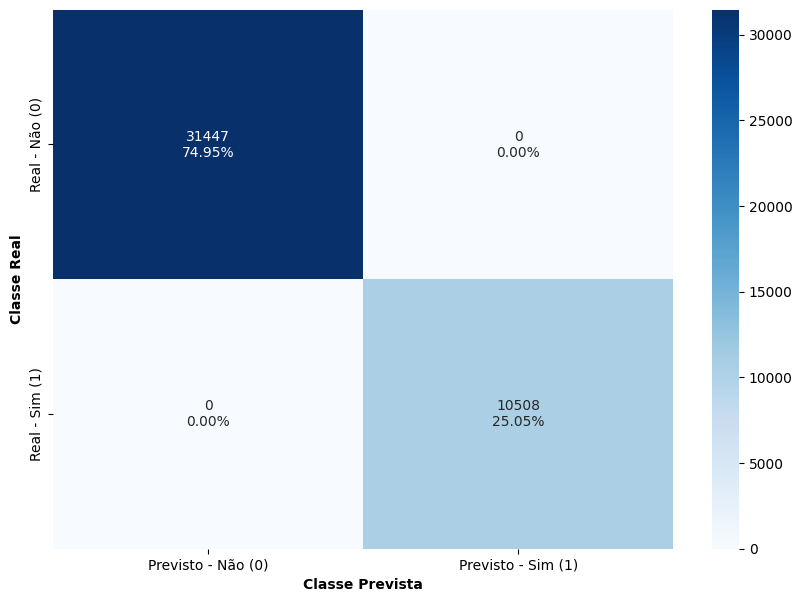

In [485]:
# Matriz de Confusão de treino
matriz_confusao(arvore_d, X_train, y_train)

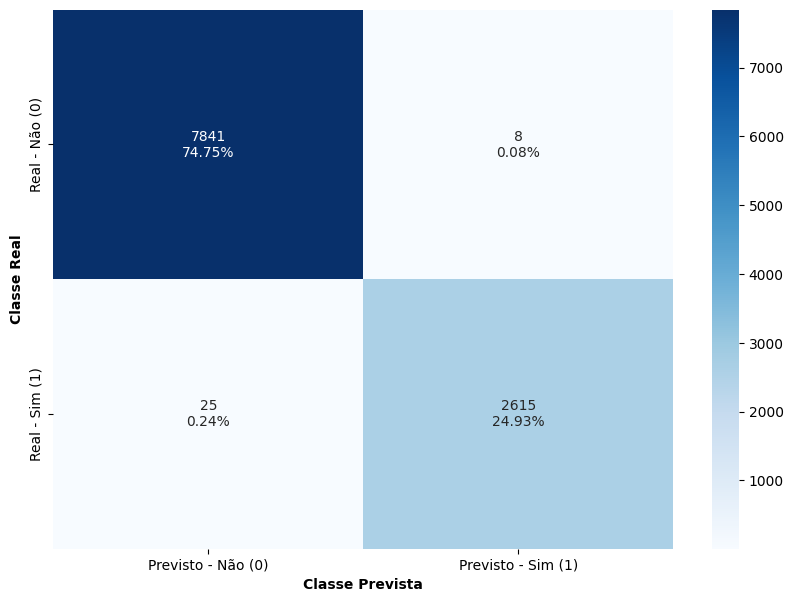

In [486]:
# Matriz de Confusão de teste
matriz_confusao(arvore_d, X_test, y_test)

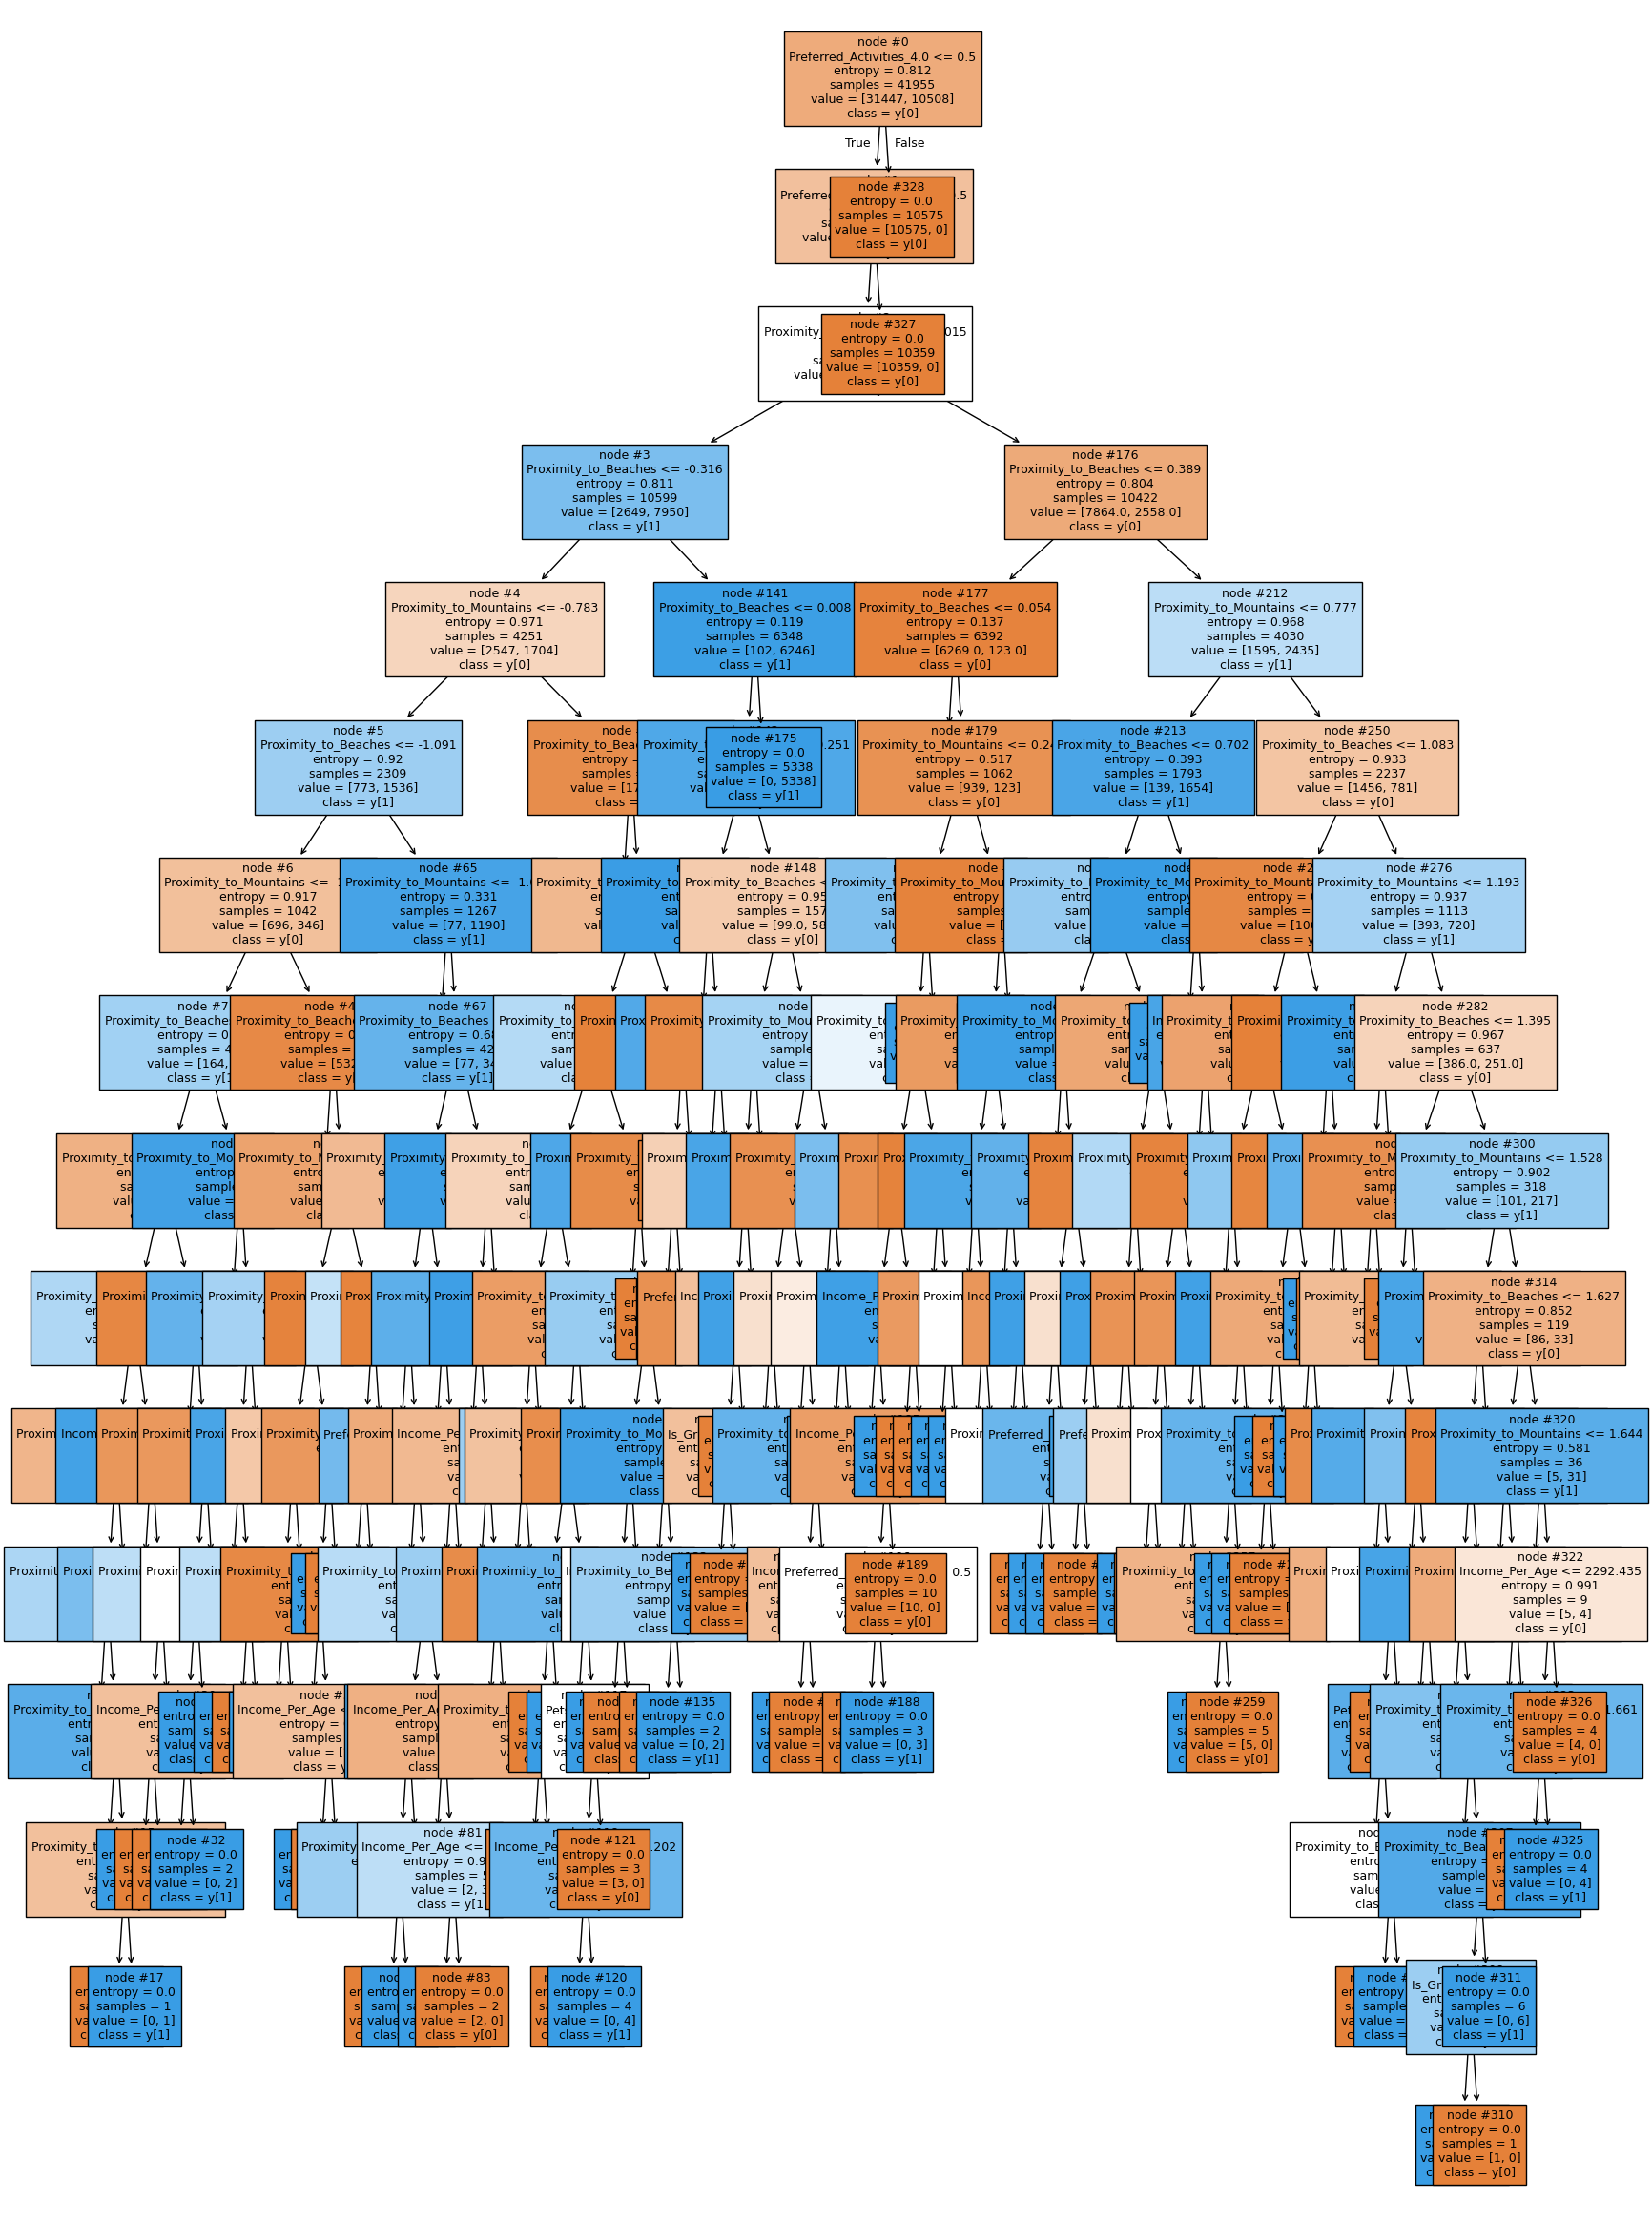

In [487]:
# Plot da árvore
feature_names = list(X_train.columns)

plt.figure(figsize=(20, 30))
tree.plot_tree(arvore_d, feature_names=feature_names, filled=True,
            fontsize=9, node_ids=True, class_names=True);

In [488]:
# Instanciando o modelo de Árvore de Decisão com Poda
arvore_d1 = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=3)

# Treinando o modelo
arvore_d1.fit(X_train, y_train)

# Avaliando o modelo no conjunto de treino e teste
print("### Avaliação do Modelo de Árvore de Decisão ###")
arvore_d1_scores = performance_modelo_classificacao(arvore_d1, X_train, X_test, y_train, y_test)

### Avaliação do Modelo de Árvore de Decisão ###
Acurácia na base de Treino: 0.8759
Acurácia na base de Teste: 0.8751

Recall na base de Treino: 0.7566
Recall na base de Teste: 0.7553

Precisão na base de Treino: 0.7501
Precisão na base de Teste: 0.7502

F1-Score na base de Treino: 0.7533
F1-Score na base de Teste: 0.7527


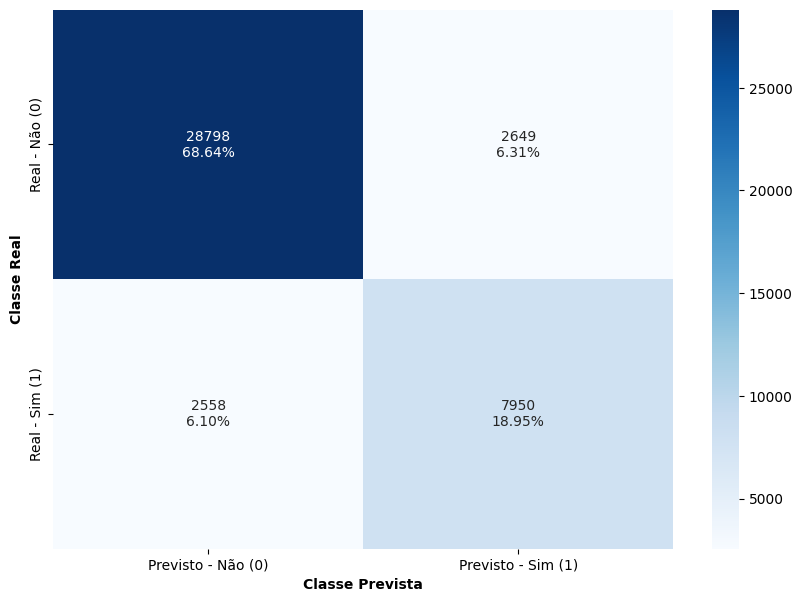

In [489]:
# Matriz de Confusão de treino
matriz_confusao(arvore_d1, X_train, y_train)

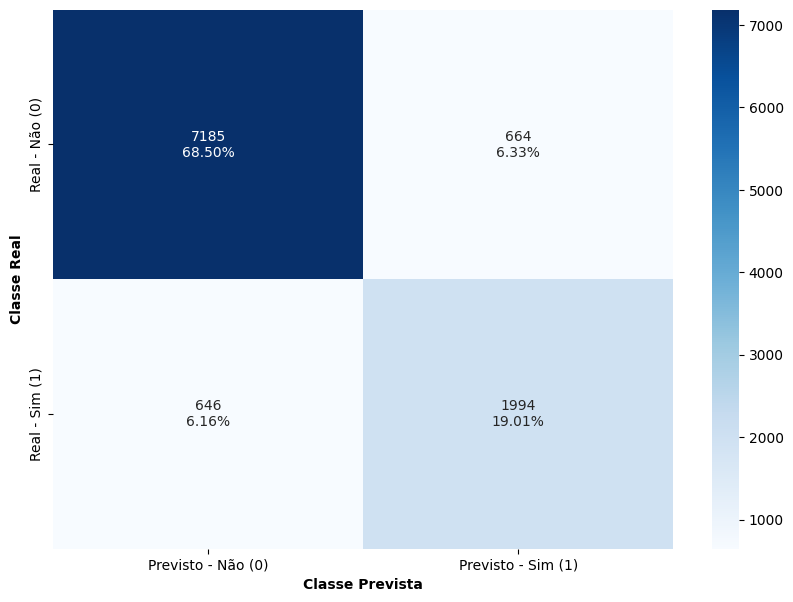

In [490]:
# Matriz de Confusão de teste
matriz_confusao(arvore_d1, X_test, y_test)

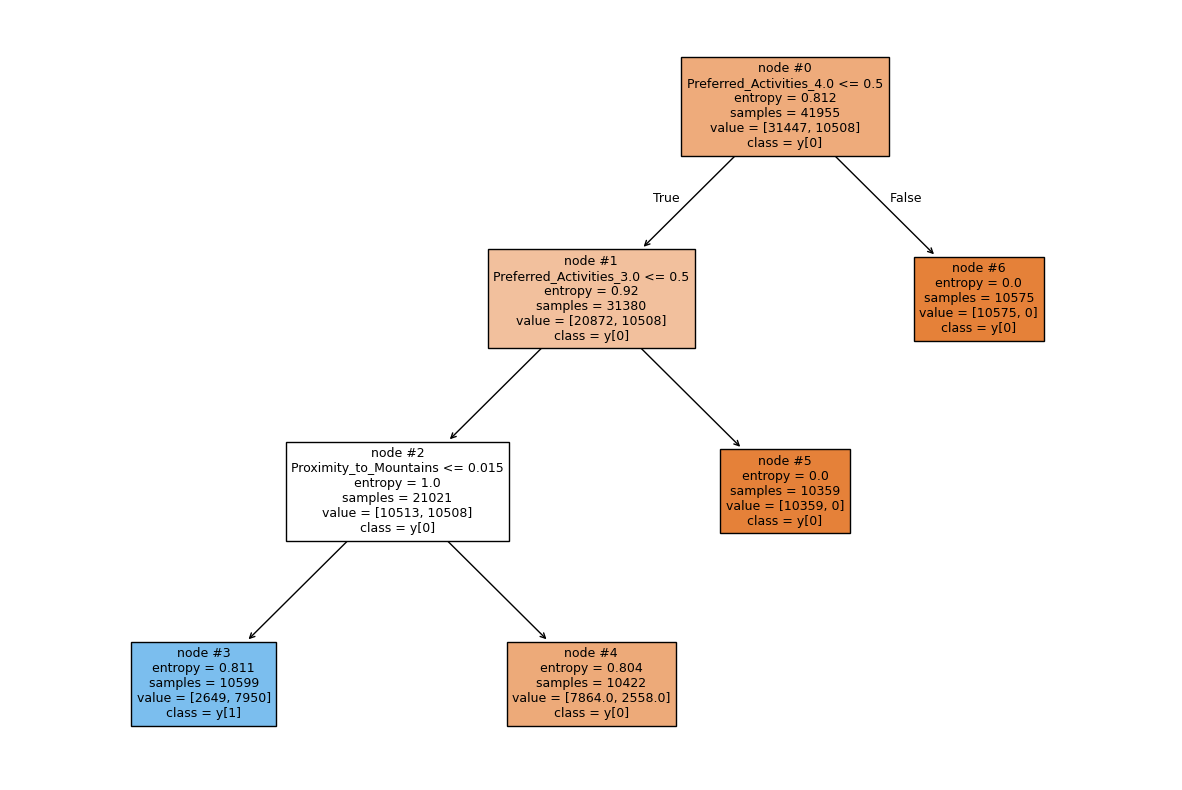

In [491]:
feature_names = list(X_train.columns)

plt.figure(figsize=(15, 10))
tree.plot_tree(arvore_d1, feature_names=feature_names, filled=True,
            fontsize=9, node_ids=True, class_names=True);